# 🎥🍿 Fine-tuning DistilBert for IMDB Movie Reviews Sentiment Analysis

### 📔 Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict

### 🔢 Dataset

In [ ]:
!pip install -U datasets huggingface_hub fsspec # install this fix the bug "ValueError: Invalid pattern: ‘**’ can only be an entire path component"

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


In [ ]:
from datasets import load_dataset
from google.colab import userdata
from huggingface_hub import login
import os

# 1. Retrieve your Hugging Face API token from Colab's Userdata secrets
# Make sure you have a secret named 'huggingface' in Colab secrets
# (Tools -> Secrets -> + New secret -> Name: huggingface, Value: your_hf_token)
hf_token = userdata.get('huggingface')
# user_secrets = UserSecretsClient()
# hf_token = user_secrets.get_secret("hugging_face")

# 2. Log in to Hugging Face Hub using the retrieved token
# This is necessary if the dataset is private or for certain operations
if hf_token:
    login(token=hf_token)
    print("Successfully logged in to Hugging Face Hub!")
else:
    print("Hugging Face token not found in Colab secrets. Proceeding without login (may fail for private datasets).")

# 3. Load the dataset
# If the dataset is public, this might work even without explicit login if no token is needed.
# If it's private or requires a token for access, the login step above is crucial.
try:
    ds = load_dataset("ajaykarthick/imdb-movie-reviews")
    print("\nDataset loaded successfully!")
    print(ds) # Print the dataset structure to confirm
    print(ds['train'][0]) # Print the first example from the training split
except Exception as e:
    print(f"\nError loading dataset: {e}")
    print("Please ensure the dataset exists, is public, or your Hugging Face token is correct and has access.")

# You can now work with the 'ds' object, which is a DatasetDict
# For example, to access the training split:
# train_dataset = ds['train']
# print(train_dataset[0])

Successfully logged in to Hugging Face Hub!

Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})
{'review': "Ms Aparna Sen, the maker of Mr & Mrs Iyer, directs this movie about a young girl's struggle to cope with her debilitating condition.<br /><br />Meethi (Konkona Sen) has been an aloof kid ever since childhood and has shown signs of delusion, no one knows why. The dormant tendency however slips out of control, when the job assignment takes her to neighboring Bihar where she's raped by some political goons. The resulting trauma also leads to episodes of manic-depressive psychosis in addition to her schizophrenia. She careens out of control over the years, progressively getting worse and sinking deeper into her private 'world'.<br /><br />The juxtaposition of an 'unsettled' (divorced) elder sister and how her d

In [ ]:
# turn ds into dataframe to make it ez to work with
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

In [ ]:
# visualize the table
train_df.head()

,review,label
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0
1,"I have seen this film only once, on TV, and it...",0
2,I was only fourteen when I first saw the Alien...,1
3,This marvelous short will hit home with everyo...,0
4,If you are 10 years old and never seen a movie...,1


**Note that 0 is negative and 1 is positive in this dataset. This is against the common label encoding practice of most dataset. So we are going to flip the label**


### 🩺 EDA

In [ ]:
# inverting the label 0 -> 1 and 1 -> 0
train_df['label'] = train_df['label'].apply(lambda x: 1 - x)
train_df.head()

,review,label
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",1
1,"I have seen this film only once, on TV, and it...",1
2,I was only fourteen when I first saw the Alien...,0
3,This marvelous short will hit home with everyo...,1
4,If you are 10 years old and never seen a movie...,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
# take a look at a sample
train_df.sample(1)

,review,label
3220,"Adapted from Sam Shepard's play, this movie re...",1


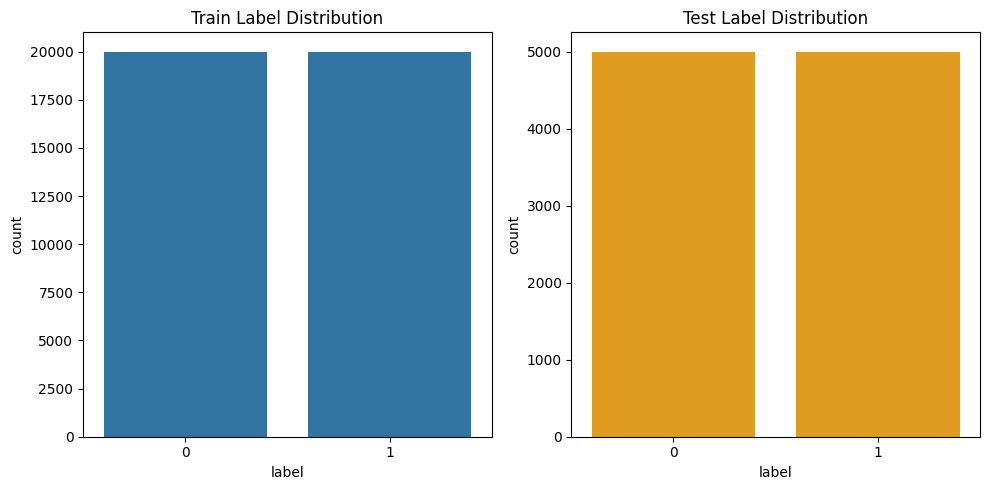

In [ ]:
# check for class balance
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=train_df, x='label', ax=ax[0])
ax[0].set_title("Train Label Distribution")

sns.countplot(data=test_df, x='label', ax=ax[1], color='orange')
ax[1].set_title("Test Label Distribution")

plt.tight_layout()
plt.show()

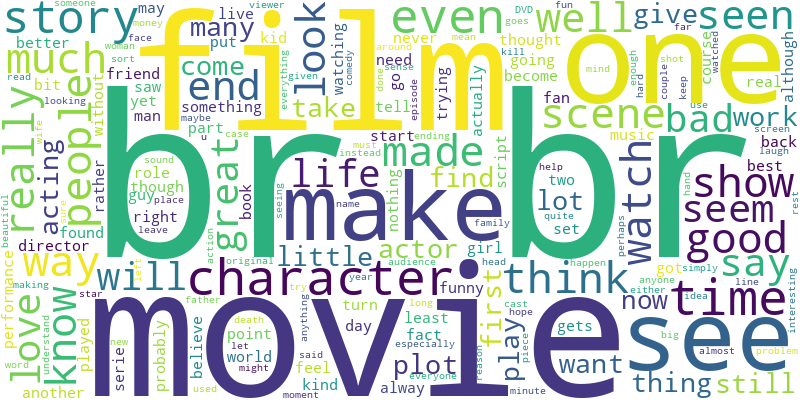

In [ ]:
# using wordcloud to visualize
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color='white')
wc.generate(" ".join(train_df['review'])).to_image()

### ♻️ Preprocessing & Text Normalization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from scipy.special import softmax

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

### Convert Dataframe to Dataset

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(test_df)

In [ ]:
# # convert to list
# train_texts = train_df['review'].to_list()
# train_labels = train_df['label'].to_list()
# test_texts = test_df['review'].to_list()
# test_labels = test_df['label'].to_list()

In [ ]:
print(type(train_dataset[0]['review']))

<class 'str'>


### Tokenize the input

In [ ]:
### TOKENIZE FUNCTION ###
def tokenize_function(batch):
  # when process in batch,
  return tokenizer(list(batch['review']), padding='max_length', truncation=True)

In [ ]:
# train_tokenized = tokenize_function(train_dataset)
# eval_tokenized = tokenize_function(eval_dataset)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
eval_tokenized = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Padding, making all sentences the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 👾 Fine-tune DistilBERT Pretrained Model

### Prepare for training
- Remove the columns corresponding to values the model does not expect.

- Rename the column label to labels (because the model expects the argument to be named labels).
- Set the format of the datasets so they return PyTorch tensors instead of lists.

In [ ]:
# check the current columns
train_tokenized.column_names

['review', 'label', 'input_ids', 'attention_mask']

In [ ]:
# remove the columns the model doesn't expect
train_tokenized = train_tokenized.remove_columns(['review'])
# rename label to labels
train_tokenized = train_tokenized.rename_column('label', 'labels')

In [ ]:
# remove the columns the model doesn't expect
eval_tokenized = eval_tokenized.remove_columns(['review'])
# rename label to labels
eval_tokenized = eval_tokenized.rename_column('label', 'labels')

In [ ]:
# set the format to return pytorch tensors instead of lists
train_tokenized.set_format("torch")
eval_tokenized.set_format("torch")

train_tokenized.column_names

['labels', 'input_ids', 'attention_mask']

### Turn data into an iterable object using DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_tokenized, shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    eval_tokenized, batch_size=8, collate_fn=data_collator
)

# Sanity Check

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

In [ ]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.0423, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


All 🤗 Transformers models will return the loss when labels are provided, and we also get the logits (two for each input in our batch, so a tensor of size 8 x 2).

### Optimizer and Learning rate scheduler

In [ ]:
# Optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

In [ ]:
# learning rate scheduler
from transformers import get_scheduler

num_epochs = 3 # consider decreasing to 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
print(num_training_steps)

15000


### GPU Training

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

### Training Loop

In [ ]:
from tqdm.auto import tqdm # for progress bar

progress_bar = tqdm(range(num_training_steps))

# put model in training mode
model.train()

for epoch in range(num_epochs):
  # loop through the batches
    for batch in train_dataloader:
        # turn the batch into a dictionary
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss # calculate loss
        loss.backward() # propagate backward

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
model.save_pretrained("distilbert_finetuned_model")
tokenizer.save_pretrained("distilbert_finetuned_tokenizer_model")

('distilbert_finetuned_tokenizer_model/tokenizer_config.json',
 'distilbert_finetuned_tokenizer_model/special_tokens_map.json',
 'distilbert_finetuned_tokenizer_model/vocab.txt',
 'distilbert_finetuned_tokenizer_model/added_tokens.json',
 'distilbert_finetuned_tokenizer_model/tokenizer.json')

### Evaluation loop

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import evaluate

# for classification report and confusion matrix
all_preds = []
all_labels = []
all_probs = []

# load relevant metric for sentiment analysis
accuracy_metric = evaluate.load("accuracy")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")
f1_metric = evaluate.load("f1")

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits # logit = (batch_size, class_score)
    # collecting probs, see how confident each prediction is
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(logits, dim=-1) # extract the class_score located in the last column

    # collecting metrics
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])

    # save predictions
    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())
    all_probs.extend(probs.cpu().numpy())

In [ ]:
model.save_pretrained("distilbert_finetuned_model")
tokenizer.save_pretrained("distilbert_finetuned_tokenizer_model")

('distilbert_finetuned_tokenizer_model/tokenizer_config.json',
 'distilbert_finetuned_tokenizer_model/special_tokens_map.json',
 'distilbert_finetuned_tokenizer_model/vocab.txt',
 'distilbert_finetuned_tokenizer_model/added_tokens.json',
 'distilbert_finetuned_tokenizer_model/tokenizer.json')

### Classification report

In [ ]:
distilbert_report = classification_report(all_labels, all_preds, target_names=['Negative','Positive'])

### Confusion Matrix

In [ ]:
# plot confusion matrix
cm_bert= confusion_matrix(all_labels, all_preds)
# display
cm_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=['Positive', 'Negative'])

cm_bert.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

### Save the model

In [ ]:
model.save_pretrained("distilbert_finetuned_model")
tokenizer.save_pretrained("distilbert_finetuned_tokenizer_model")